## 共通処理

In [2]:
# 必要なパッケージをインポート
# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# pandas用ライブラリ
import pandas as pd
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

import random

In [3]:
import pymc as pm
import arviz as az

## ch5

### 階層ベイズモデル: 似た傾向にある他の花のデータを参考に、精度の高いモデリングを行う

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.000,3.500,1.300,0.300,setosa
1,5.000,3.400,1.500,0.200,setosa
2,4.900,3.000,1.400,0.200,setosa
3,5.500,2.600,4.400,1.200,versicolor
4,4.900,2.400,3.300,1.000,versicolor
5,6.400,3.200,4.500,1.500,versicolor
6,6.700,3.100,5.600,2.400,virginica
7,7.300,2.900,6.300,1.800,virginica
8,5.800,2.700,5.100,1.900,virginica


<Axes: xlabel='sepal_length', ylabel='sepal_width'>

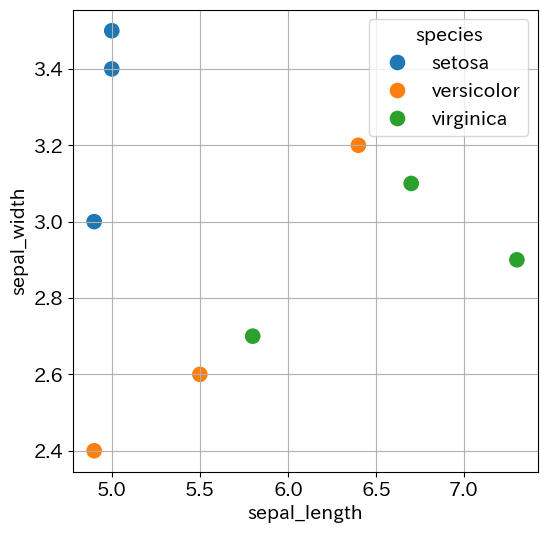

In [10]:
# 分析データの可視化
df = sns.load_dataset("iris")

df0 = df[df["species"] == "setosa"]
df1 = df[df["species"] == "versicolor"]
df2 = df[df["species"] == "virginica"]

random.seed(42)
indexes = range(len(df0))
sample_indexes = random.sample(indexes, 3)

df0_less = df0.iloc[sample_indexes]
df1_less = df1.iloc[sample_indexes]
df2_less = df2.iloc[sample_indexes]

df_less = pd.concat([df0_less, df1_less, df2_less], axis = 0).reset_index(drop=True)
display(df_less)

sns.scatterplot(data = df_less, x = "sepal_length", y = "sepal_width", 
                hue = "species", s = 150)

In [16]:
# データ準備
X = df_less["sepal_length"].values
Y = df_less["sepal_width"].values
species = df_less["species"]
cl = pd.Categorical(species).codes

print(species.values)
print(cl)

['setosa' 'setosa' 'setosa' 'versicolor' 'versicolor' 'versicolor'
 'virginica' 'virginica' 'virginica']
[0 0 0 1 1 1 2 2 2]


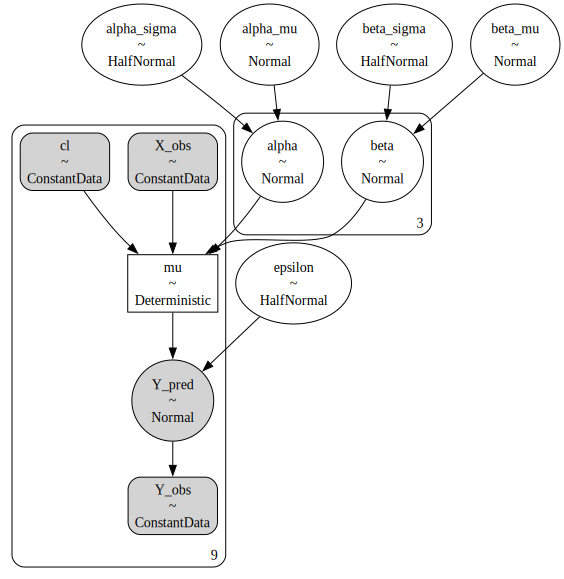

In [19]:
# 確率モデル構造の定義
model = pm.Model()

with model:
    # X, Yの観測値をConstantDataとして定義
    X_obs = pm.ConstantData("X_obs", X)
    Y_obs = pm.ConstantData("Y_obs", Y)

    # 確率変数であるパラメータのクラス変数をConstantDataとして定義
    cl_obs = pm.ConstantData("cl", cl)

    # alphaを傾きの確率変数として定義
    alpha_mu = pm.Normal("alpha_mu", mu = 0, sigma = 10.0)
    alpha_sigma = pm.HalfNormal("alpha_sigma", sigma = 10.0)
    alpha = pm.Normal("alpha", mu = alpha_mu, sigma = alpha_sigma, shape=(3,))

    # betaを切片の確率変数として定義
    beta_mu = pm.Normal("beta_mu", mu = 0, sigma = 10.0)
    beta_sigma = pm.HalfNormal("beta_sigma", sigma = 10.0)
    beta = pm.Normal("beta", mu = beta_mu, sigma = beta_sigma, shape=(3,))

    # 平均値をmを確率変数として定義。またcl_obsでインデックスを切り替えて計算。
    mu = pm.Deterministic("mu", X_obs*alpha[cl_obs] + beta[cl_obs])

    # 誤差を確率変数として定義
    epsilon = pm.HalfNormal("epsilon", sigma = 10)

    # Y_predを観測値Y_obsを持つ確率変数として定義
    Y_pred = pm.Normal("Y_pred", mu = mu, sigma = epsilon, observed = Y_obs)

display(pm.model_to_graphviz(model))



In [20]:
# サンプリング
with model:
    idata = pm.sample(random_seed = 42, chains = 2, 
                      tune=1000, draws=1000, 
                      target_accept = 0.998)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha_mu, alpha_sigma, alpha, beta_mu, beta_sigma, beta, epsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 693 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.531,0.535,-0.355,1.572,0.022,0.020,479.000,494.000,1.000
alpha[1],0.424,0.259,-0.082,0.887,0.016,0.011,269.000,312.000,1.010
alpha[2],0.285,0.241,-0.151,0.783,0.012,0.008,412.000,549.000,1.010
beta[0],0.643,2.647,-4.363,5.223,0.109,0.098,510.000,506.000,1.000
beta[1],0.375,1.467,-2.247,3.274,0.090,0.064,267.000,327.000,1.000
beta[2],1.026,1.598,-1.950,4.257,0.077,0.055,413.000,524.000,1.010


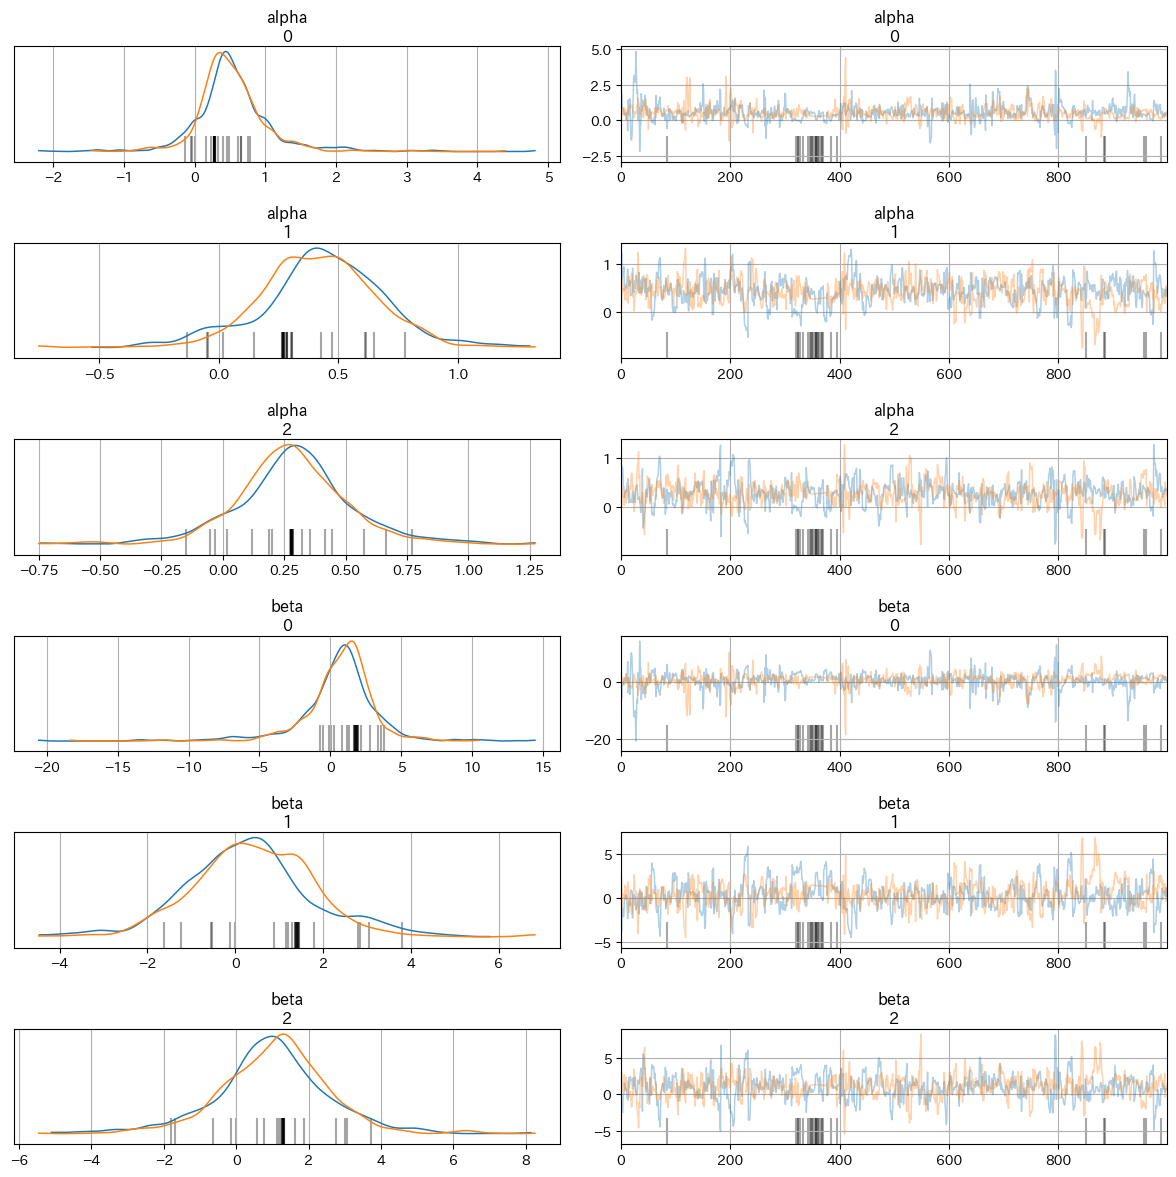

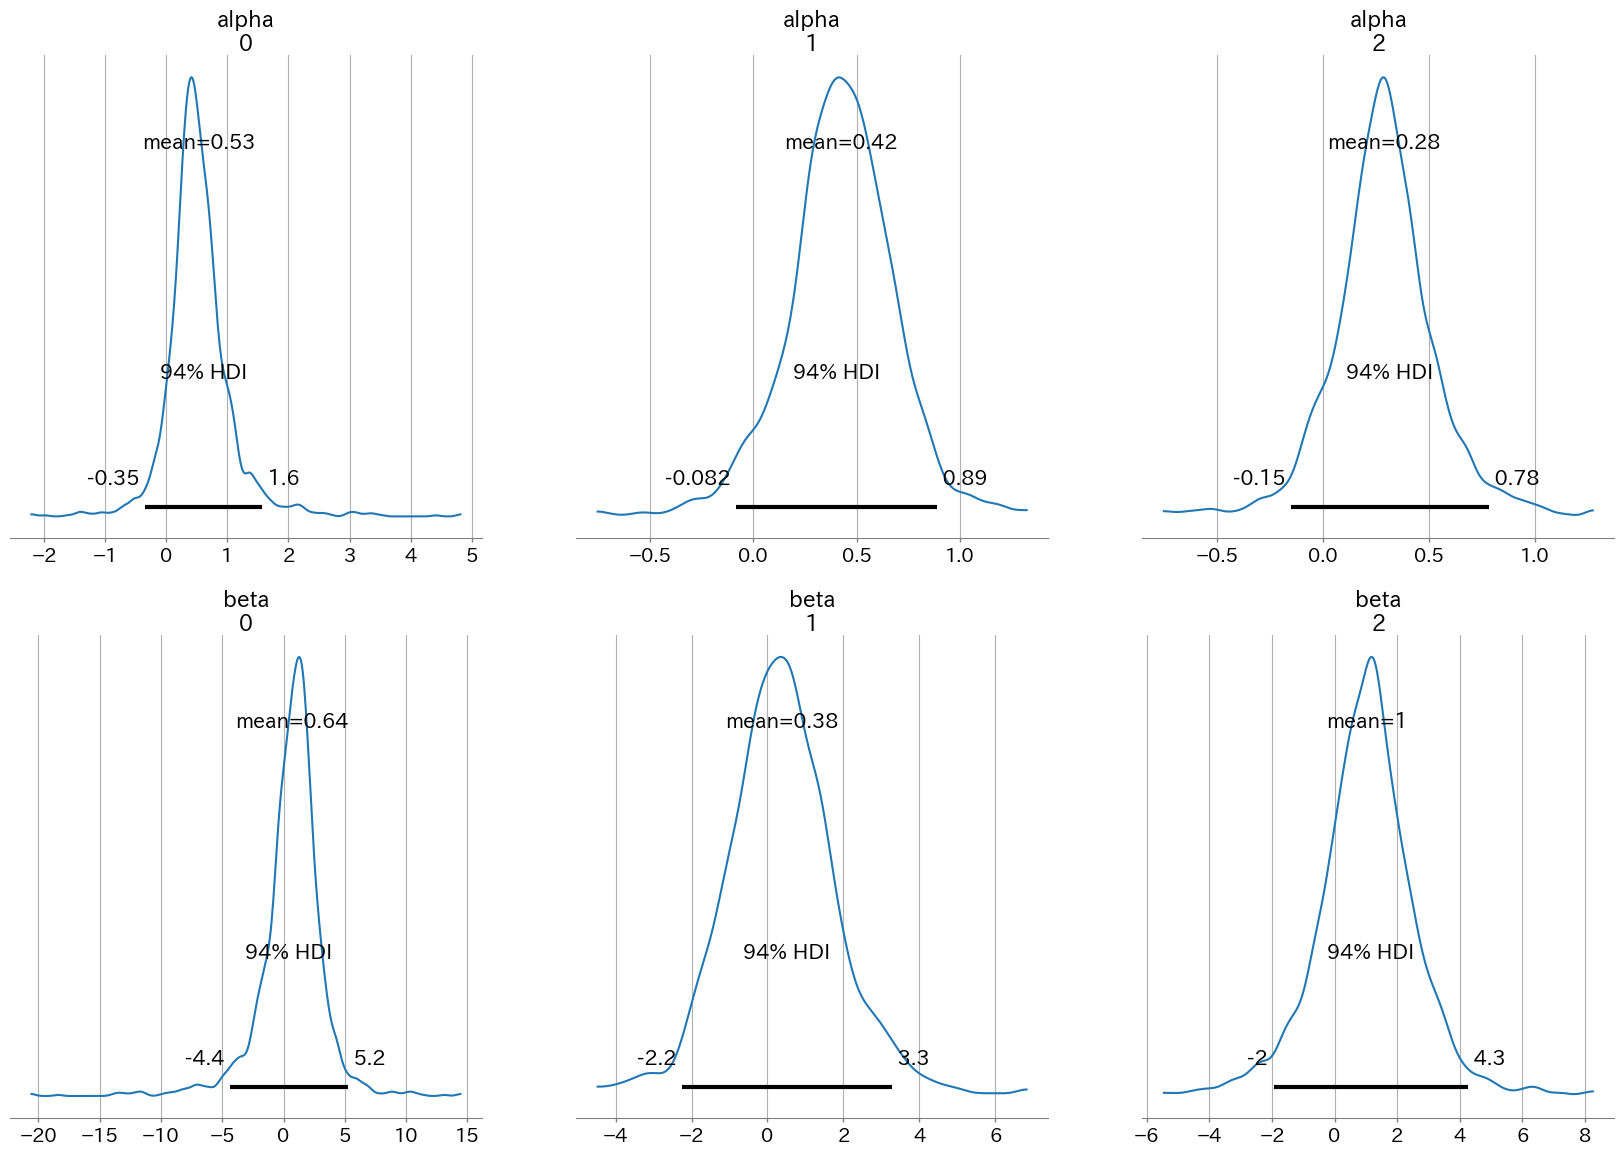

In [21]:
az.plot_trace(idata, compact = False, var_names=["alpha", "beta"])
plt.tight_layout();
az.plot_posterior(idata, var_names = ["alpha", "beta"]);

summary = az.summary(idata, var_names = ["alpha", "beta"])
display(summary)

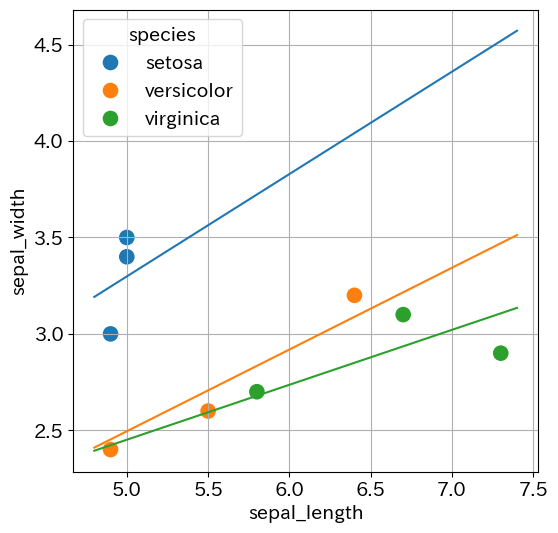

In [22]:
# 散布図と回帰直線(平均値)の描画

# パラメーターの平均値抽出
means = summary["mean"]
alpha0 = means["alpha[0]"]
alpha1 = means["alpha[1]"]
alpha2 = means["alpha[2]"]
beta0 = means["beta[0]"]
beta1 = means["beta[1]"]
beta2 = means["beta[2]"]

# 回帰直線用の座標計算
x_range = np.array([X.min()-0.1, X.max()+0.1])
y0 = alpha0 * x_range + beta0
y1 = alpha1 * x_range + beta1
y2 = alpha2 * x_range + beta2

sns.scatterplot(data = df_less, x = "sepal_length", y = "sepal_width", 
                hue = "species", s = 150)
plt.plot(x_range, y0)
plt.plot(x_range, y1)
plt.plot(x_range, y2)

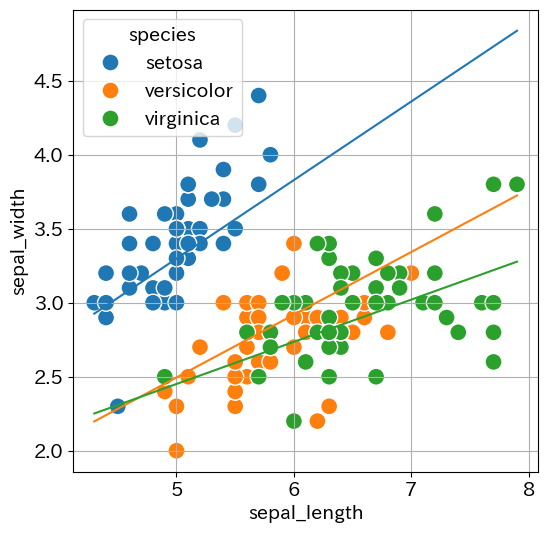

In [29]:
# 散布図(全データ)と回帰直線の描画

# パラメーターの平均値抽出
means = summary["mean"]
alpha0 = means["alpha[0]"]
alpha1 = means["alpha[1]"]
alpha2 = means["alpha[2]"]
beta0 = means["beta[0]"]
beta1 = means["beta[1]"]
beta2 = means["beta[2]"]

# 回帰直線用の座標計算
x_range = np.array([df["sepal_length"].min(), df["sepal_length"].max()])
y0 = alpha0 * x_range + beta0
y1 = alpha1 * x_range + beta1
y2 = alpha2 * x_range + beta2

sns.scatterplot(data = df, x = "sepal_length", y = "sepal_width", 
                hue = "species", s = 150)
plt.plot(x_range, y0)
plt.plot(x_range, y1)
plt.plot(x_range, y2)

(2.0, 5.0)

/Users/wakamatsuikuma/.pyenv/versions/3.10.7/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/wakamatsuikuma/.pyenv/versions/3.10.7/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


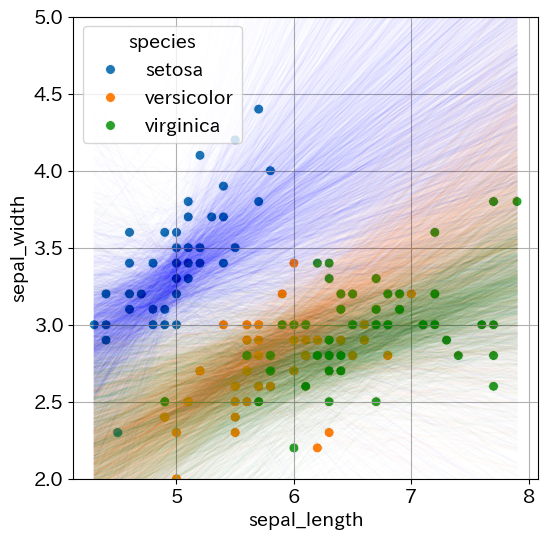

In [87]:
# 散布図(全データ)と回帰直線(幅あり)の描画

# パラメーターの平均値抽出
ifr = idata["posterior"]
alpha_ifr0 = ifr["alpha"].values.reshape(-1, 3)[:, 0].reshape(2000, 1)
alpha_ifr1 = ifr["alpha"].values.reshape(-1, 3)[:, 1].reshape(2000, 1)
alpha_ifr2 = ifr["alpha"].values.reshape(-1, 3)[:, 2].reshape(2000, 1)
beta_ifr0 = ifr["beta"].values.reshape(-1, 3)[:, 0].reshape(2000, 1)
beta_ifr1 = ifr["beta"].values.reshape(-1, 3)[:, 1].reshape(2000, 1)
beta_ifr2 = ifr["beta"].values.reshape(-1, 3)[:, 2].reshape(2000, 1)

# 回帰直線用の座標計算
x_range = np.array([df["sepal_length"].min(), df["sepal_length"].max()])
y0 = alpha_ifr0 * x_range + beta_ifr0
y1 = alpha_ifr1 * x_range + beta_ifr1
y2 = alpha_ifr2 * x_range + beta_ifr2

sns.scatterplot(data = df, x = "sepal_length", y = "sepal_width", 
                hue = "species", s = 50)

for y_pred in y0:
    plt.plot(x_range, y_pred, lw=1, alpha=0.01, c="b") # 回帰直線
for y_pred in y1:
    plt.plot(x_range, y_pred, lw=1, alpha=0.01, c="#ff7f00") # 回帰直線
for y_pred in y2:
    plt.plot(x_range, y_pred, lw=1, alpha=0.01, c="g") # 回帰直線
plt.ylim(2, 5)